# **CISC3024 Pattern Recognition Final Project**
## Group Members:
- Huang Yanzhen, DC126732
- Mai Jiajun, DC12785

# 0. Project Setup

## 0.1 Packages & Device

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import numpy as np
import cv2
import os

In [8]:
device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
print(f"Using device: {device_name}")

Using device: cuda


## 0.2 Global Configurations

In [9]:
path_dataset = "./data/SVHN_mat"
norm_mean = [0.4377, 0.4438, 0.4728]
norm_std = [0.1980, 0.2010, 0.1970]

# 1. Data Processing and Augmentation

## 1.1 Download Datasets
Define dataset class, retrieve dataset.

In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import scipy.io as sio

In [11]:
class SVHNDataset(Dataset):
    def __init__(self, mat_file, transform=None):
        data = sio.loadmat(mat_file)
        self.images = np.transpose(data['X'], (3, 0, 1, 2))
        self.labels = data['y'].flatten()
        self.labels[self.labels == 10] = 0
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image=image)['image']

        return image, label

In [12]:
transform = A.Compose([
    A.RandomResizedCrop(32, 32),
    A.Rotate(limit=30),
    A.Normalize(mean=norm_mean, std=norm_std),
    ToTensorV2()
])

train_dataset = SVHNDataset(mat_file=os.path.join(path_dataset,"train_32x32.mat"), transform=transform)
test_dataset = SVHNDataset(mat_file=os.path.join(path_dataset,"test_32x32.mat"), transform=transform)
extra_dataset = SVHNDataset(mat_file=os.path.join(path_dataset,"extra_32x32.mat"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
extra_loader = DataLoader(extra_dataset, batch_size=64, shuffle=False)

print(f"Train Size:{train_dataset.__len__()}\nTest Size:{test_dataset.__len__()}\nExtra Size:{extra_dataset.__len__()}")

Train Size:73257
Test Size:26032
Extra Size:531131


## 1.2 Peak A Data

In [13]:
import random

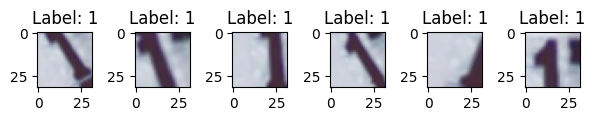

Peaking data from training set of index 67394.
Image Tnesor Size:torch.Size([3, 32, 32])


In [14]:
def unnormalize(img, mean, std):
    """Revert the normalization for visualization."""
    img = img * std + mean
    return np.clip(img, 0, 1)

# Plotting multiple images in a grid
grid_rows, grid_cols = 1, 6

fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(6, 6))

peak_index = random.randint(0, train_dataset.__len__()-1)

for i in range(grid_cols):
    img_tensor, label = train_dataset.__getitem__(peak_index)
    img = img_tensor.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
    img = unnormalize(img, norm_mean, norm_std)

    ax = axes[i]  # Get subplot axis
    ax.imshow(img)
    ax.set_title(f"Label: {label}")

plt.tight_layout()
plt.show()

print(f"Peaking data from training set of index {peak_index}.\nImage Tnesor Size:{train_dataset.__getitem__(peak_index)[0].shape}")

# 2. Neuron Network Structure

## 2.1 Specify Model Structure

In [15]:
class SmallVGG(nn.Module):
    def __init__(self, batch_size=32):
        super(SmallVGG, self).__init__()
        self.batch_size = batch_size
        self. conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16x16

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8x8

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 4x4
        )
    
        self.fc_layers = nn.Sequential(
            nn.Linear(batch_size * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

## 2.2 Initialize with Hyper Parameters

In [16]:
model = SmallVGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

## 2.3 Train and Evaluate

In [17]:
def train_and_evaluate(model,
                      train_loader,
                      test_loader,
                      criterion,
                      optimizer,
                      num_epochs=100):
    # Record Losses to plot
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # Train
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * len(images)
        train_losses.append(running_loss / len(train_loader))

        # Evaluate
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * len(images)

        test_losses.append(test_loss / len(test_loader))
        print(f"Epoch[{epoch+1}/{num_epochs}], Train Loss:{train_losses[-1]:.4f}, Test Loss:{test_losses[-1]:.4f}")

    return train_losses, test_losses

In [18]:
train_losses, test_losses = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs)

100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:13<00:00, 43.34it/s]


Epoch[1/20], Train Loss:272.9408, Test Loss:227.0916


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 52.73it/s]


Epoch[2/20], Train Loss:189.4755, Test Loss:158.6697


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 54.98it/s]


Epoch[3/20], Train Loss:153.0620, Test Loss:144.0663


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 53.20it/s]


Epoch[4/20], Train Loss:138.3524, Test Loss:133.4725


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 53.88it/s]


Epoch[5/20], Train Loss:131.8362, Test Loss:126.0268


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 52.95it/s]


Epoch[6/20], Train Loss:128.1622, Test Loss:122.8448


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 53.08it/s]


Epoch[7/20], Train Loss:124.5899, Test Loss:117.7321


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 52.98it/s]


Epoch[8/20], Train Loss:121.9194, Test Loss:119.0376


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:14<00:00, 39.57it/s]


Epoch[9/20], Train Loss:119.4151, Test Loss:112.2788


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:11<00:00, 48.67it/s]


Epoch[10/20], Train Loss:117.7706, Test Loss:114.7637


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:11<00:00, 51.61it/s]


Epoch[11/20], Train Loss:116.1206, Test Loss:110.8553


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 55.28it/s]


Epoch[12/20], Train Loss:114.9764, Test Loss:108.3019


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 56.86it/s]


Epoch[13/20], Train Loss:113.4658, Test Loss:108.7244


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 55.01it/s]


Epoch[14/20], Train Loss:112.0956, Test Loss:109.0502


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:11<00:00, 51.27it/s]


Epoch[15/20], Train Loss:111.3249, Test Loss:107.1411


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 53.90it/s]


Epoch[16/20], Train Loss:110.6058, Test Loss:106.7615


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 54.89it/s]


Epoch[17/20], Train Loss:109.7378, Test Loss:105.6679


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:11<00:00, 48.76it/s]


Epoch[18/20], Train Loss:110.2537, Test Loss:104.4986


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:10<00:00, 52.96it/s]


Epoch[19/20], Train Loss:109.1750, Test Loss:105.4514


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:11<00:00, 49.49it/s]


Epoch[20/20], Train Loss:108.3806, Test Loss:104.6703


## 2.4 Visualize Result

### 2.4.1 Epoch-Loss Curves

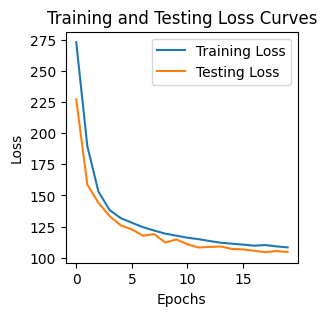

In [19]:
plt.figure(figsize=(3,3))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing Loss Curves")
plt.legend()
plt.show()

### 2.4.2 Confusion Matrix

In [20]:
extra_loader

In [22]:
model.eval() 
out = []
for images, labels in tqdm(test_loader):
    images = images.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    out += outputs

100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [00:06<00:00, 29.80it/s]


In [23]:
out

[tensor([-3.4318, -0.9983, -0.3228,  1.0333, -4.3251,  5.6965,  0.2254, -1.1882,
         -3.2776, -2.5733], device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor([-3.3164, -2.8604,  6.4932,  3.7116, -3.9534, -3.5783, -3.6160, -1.7174,
         -2.8370, -3.9299], device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor([-0.8648, -0.6123,  1.2338, -0.2775, -0.1193, -0.0991, -0.0671, -1.8977,
         -0.8573, -0.9297], device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor([ 1.5273, -4.3618,  0.5237, -1.0012, -5.9634, -1.2953,  3.0729, -3.7725,
          1.6885,  1.7581], device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor([ 0.6794,  0.9564, -1.5232, -1.3790, -2.5624,  0.0239,  2.6844, -0.8734,
         -1.7297, -3.2921], device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor([ 0.0034,  2.7296, -2.3241, -1.2407, -1.1087, -1.9754, -1.4250,  0.2705,
         -1.7182, -1.7598], device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor([-2.2549, -4.4390, -4.4371, -3.7394, -2.0128,  0.9604, -2.0463, -6.4